In [1]:
%pylab inline
import numpy as np
import pandas as pd
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
pd.options.mode.chained_assignment = None

Populating the interactive namespace from numpy and matplotlib


In [2]:
filename = 'Iris.csv'
df = pd.read_csv(filename)

In [3]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
species_encoder = LabelEncoder()
species_encoder.fit(df['Species'])
df['Species'] = species_encoder.transform(df['Species'])

In [5]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


In [6]:
df = df.sample(frac=1) # shuffle rows of dataset
target = df['Species']
inputs = df.loc[:,'SepalLengthCm':'PetalWidthCm']

In [7]:
X = inputs.values
y = target.values

In [8]:
k_fold = KFold(n_splits=5)
k_fold.get_n_splits(X)

5

In [9]:
accs = []
for train_idx, test_idx in k_fold.split(X):
    train_X, test_X = X[train_idx], X[test_idx]
    train_y, test_y = y[train_idx], y[test_idx]
    clf = linear_model.LogisticRegression()
    clf.fit(train_X, train_y)
    predictions = clf.predict(test_X)
    acc = metrics.f1_score(test_y, predictions, average='micro') # mean average percentage error
    accs.append(acc)
print(np.mean(accs))
print(np.std(accs))
print(accs)

0.96
0.0249443825785
[1.0, 0.96666666666666667, 0.96666666666666667, 0.93333333333333335, 0.93333333333333335]


In [10]:
model = InMemoryModel(clf.predict_proba, examples = train_X)

In [11]:
interpreter = Interpretation(train_X, feature_names=inputs.columns)

[4/4] features ████████████████████ Time elapsed: 0 seconds

(<matplotlib.figure.Figure at 0x1171a2fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1179924e0>)

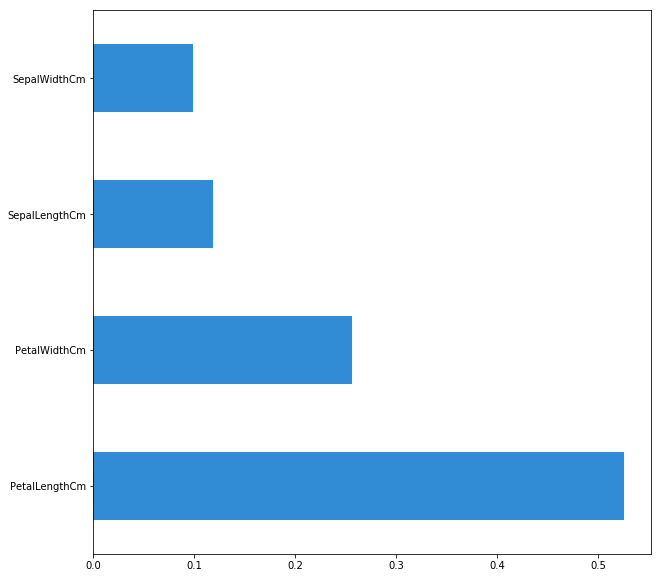

In [12]:
matplotlib.rcParams['figure.figsize'] = [10, 10]
interpreter.feature_importance.plot_feature_importance(model)

In [13]:
from sklearn.manifold import TSNE

In [14]:
tsne = TSNE(n_components=2)

In [15]:
projections = tsne.fit_transform(X)

In [16]:
def color_mapping(cl):
    colors = ['red', 'blue', 'green']
    return colors[cl]
color_mapper = np.vectorize(color_mapping)
colors = color_mapper(y)

In [17]:
def plot_classification(ax, x, y, colors, legend):
    color_set = set(colors)
    for color in color_set:
        x_curr = []
        y_curr = []
        for i, c in enumerate(colors):
            if c == color:
                x_curr.append(x[i])
                y_curr.append(y[i])
        ax.scatter(x_curr, y_curr, c=color,label=legend[color])
    

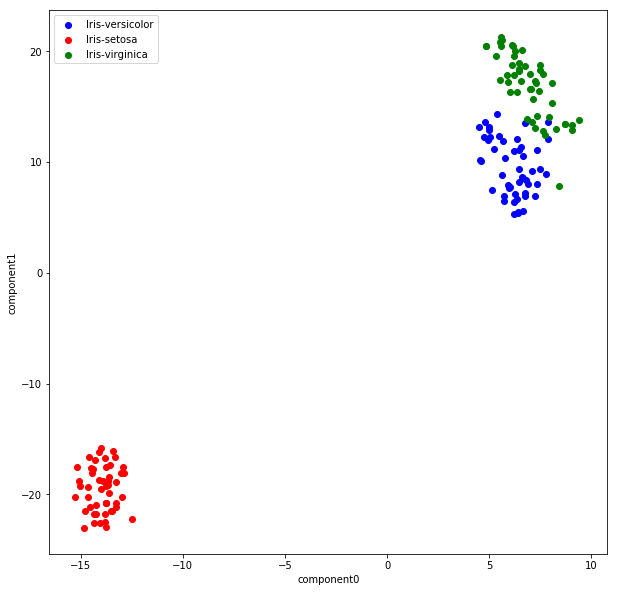

In [18]:
fig, ax = plt.subplots()
legend = {'red': species_encoder.inverse_transform(0), 
          'blue': species_encoder.inverse_transform(1),
         'green': species_encoder.inverse_transform(2)}
plot_classification(ax, projections[:,0], projections[:,1], colors, legend)
ax.set_xlabel('component0')
ax.set_ylabel('component1')
ax.legend()

In [19]:
x_coords = X[:,2] # get elements in position 2 (i.e. Petal Length) for all data points
y_coords = X[:,3] # get elements in position 3 (i.e. Petal Width) for all data points

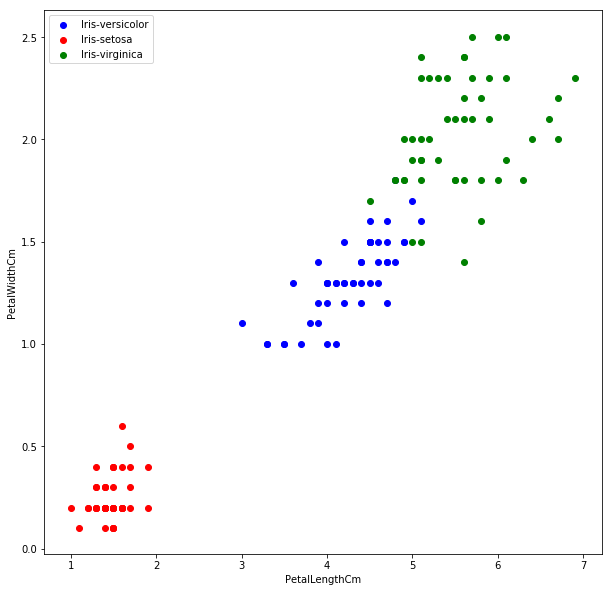

In [20]:
fig, ax = plt.subplots()
plot_classification(ax, x_coords, y_coords, colors, legend)
ax.set_xlabel('PetalLengthCm')
ax.set_ylabel('PetalWidthCm')
ax.legend()